In [1]:
import numpy as np

def generate_knot_counts(num_data_pts, degree):
    #compression_ratios = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75]
    #compression_ratios = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75]
    #compression_ratios = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7]
    compression_ratios = [0.1,0.3,0.5,0.7,0.9]

    #range_1 = [int(0.05 * x * num_data_pts) for x in range(1, 3*2)]
    #range_2 = [int(0.1 * x * num_data_pts) for x in range(3, 5)]
    #range_3 = [int(0.2 * x * num_data_pts) for x in range(5, 7)]

    #range_1 = [int(0.05 * x * num_data_pts) for x in range(1, 5 * 2)]
    #range_2 = [int(0.1 * x * num_data_pts) for x in range(5, 8)]

    #range_1 = [int(0.1 * x * num_data_pts) for x in range(0, 6)]

    #counts = range_1 #+ range_2 + range_3
    counts = [int(ratio * num_data_pts) for ratio in compression_ratios]
    for i in range(len(counts)):
        if counts[i] < degree + 1:
            counts[i] = degree + 1
            for j in range(i, len(counts) - 1):
                if counts[j + 1] <= counts[j]:
                    counts[j + 1] = counts[j] + 1

    return counts


def flatten(l):
    return [item for sublist in l for item in sublist]


def get_knot_vector(n, p):
    #return flatten((n + 1) * [[0]] + [[x / (p + 1)] for x in range(1, p + 1)] + (n + 1) * [[1]])
    return flatten((n + 1) * [[0]] + [[x / p] for x in range(1, p)] + (n + 1) * [[1]])



In [2]:
degrees = [x for x in range(5)]

In [4]:
generate_knot_counts(100, 3)

[10, 30, 50, 70, 90]

In [3]:
%%time
from load_data import load_ucr_archive, normalize_datasets

data_og = normalize_datasets(load_ucr_archive()) 

# im ersten DS sind TS mit 1460 Datenpkt und da gibts auch noch zusätzliche Probleme
#data = data[0]+data[2:]


Could not fetch CinCECGtorso. Error: Invalid dataset name =CinCECGtorso is not available on extract path =None. Nor is it available on https://timeseriesclassification.com/.
Could not fetch MixedShapes. Error: Invalid dataset name =MixedShapes is not available on extract path =None. Nor is it available on https://timeseriesclassification.com/.
Could not fetch StarlightCurves. Error: Invalid dataset name =StarlightCurves is not available on extract path =None. Nor is it available on https://timeseriesclassification.com/.
CPU times: total: 1min 1s
Wall time: 1min 10s


In [ ]:
%%time
data = [data_og[0]]

In [ ]:
%%time
from fit import fit_max_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline import evaluate_spline

# FIGURE OUT PROBLEM WITH TIME SERIES

results = []
for dataset_no, dataset in enumerate(data):
    for degree in degrees:
        counter = 0
        for i in range(len(dataset)):
            print("dataset_no",dataset_no, "degree", degree, "ts_no",i)
            time_series = dataset[i]
            counter += 1
            knots = get_knot_vector(degree, 739)
            max_dist, result = fit_max_spline(time_series, knots, degree)
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
            next_row = [i, degree, len(time_series), 739, 739 / len(time_series), max_dist, mse, mae]
            results.append(next_row)

In [12]:
from load_data import load_ucr_dataset

data = [load_ucr_dataset(48).normalize()]

In [20]:
from load_data import load_ucr_dataset

data = [load_ucr_dataset(1).normalize()]

degrees = [4]


In [31]:
def count_num_ts(data):
    counter = 0
    for dataset in data:
        for _ in dataset:
            counter += 1
    return counter


print(count_num_ts(data))

781


In [43]:
%%time
from fit import fit_max_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline import evaluate_spline

import pandas as pd

# PHASE 1: determine appropriate degree and knots (knot vector)
# not looking at outliers here
# fit spline for all predefined degrees and knot vectors
# then calculate accuracy metrics
results = []
# TODO ts_no überprüfen, iwas stimmt da nicht
for dataset_no, dataset in enumerate(data):
    for degree in degrees:
        counter = 0
        for i in range(len(dataset)):#range(len(dataset)):
            print("dataset_no",dataset_no, "degree", degree, "ts_no",i)
            time_series = dataset[i]
            counter += 1
            knot_counts = generate_knot_counts(len(time_series), degree)
            for count in knot_counts:
                knots = get_knot_vector(degree, count)
                max_dist, result = fit_max_spline(time_series, knots, degree)
                fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
                mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
                mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
                #next_row = [name, ts_no, degree, len(time_series), count, count / len(time_series), max_dist, mse, mae]
                next_row = [i, degree, len(time_series), count, count / len(time_series), max_dist, mse, mae]
                results.append(next_row)


CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
df = pd.DataFrame(results,
                  #columns=['dataset_name', 'ts_number', 'degree', 'no. of data pts', 'no. of knots', 'compression_rate','max_dist', 'MSE', 'MAE'])
                  columns=['ts_number', 'degree', 'no. of data pts', 'no. of knots', 'compression_rate', 'max_dist',
                           'MSE', 'MAE'])
df['compression_rate'] = df['compression_rate'].round(1)
df

,ts_number,degree,no. of data pts,no. of knots,compression_rate,max_dist,MSE,MAE
0,0,0,180,18,0.1,0.385792,0.116638,0.329749
1,0,0,180,90,0.5,0.054921,0.002582,0.049186
2,0,0,180,162,0.9,0.048561,0.002311,0.047883
3,1,0,90,9,0.1,1.332801,1.289762,1.105899
4,1,0,90,45,0.5,0.193361,0.029198,0.163751
...,...,...,...,...,...,...,...,...
5065,336,4,179,89,0.5,0.020027,0.000280,0.015325
5066,336,4,179,161,0.9,0.006968,0.000046,0.006700
5067,337,4,228,22,0.1,0.075134,0.002537,0.044788
5068,337,4,228,114,0.5,0.024949,0.000427,0.019245


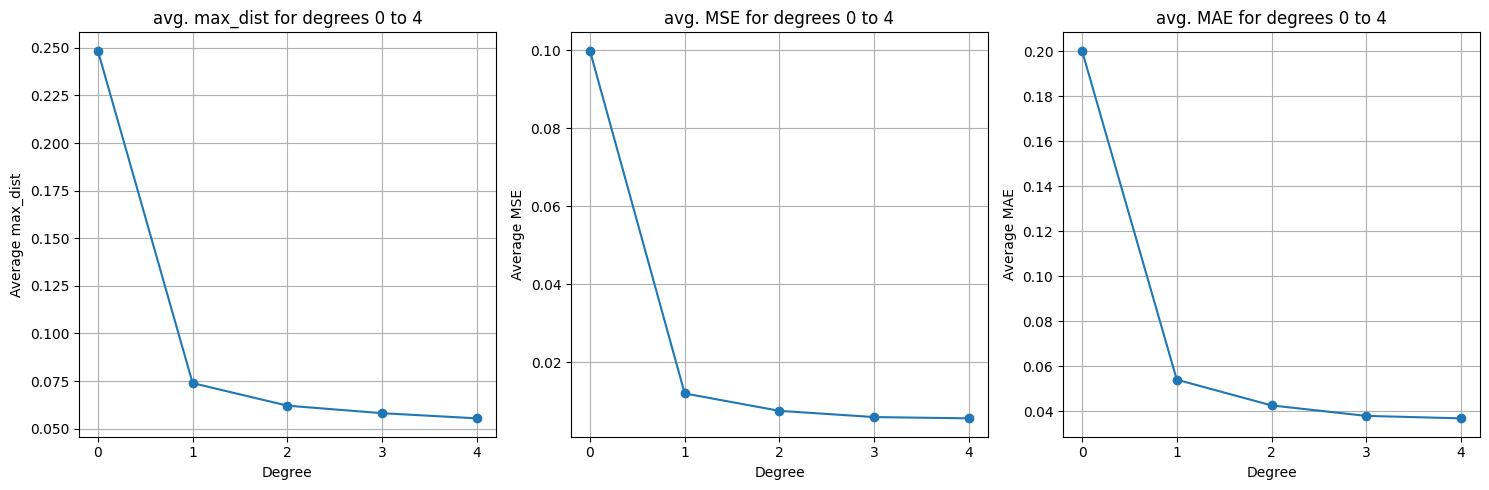

In [18]:
# degree vs avg. accuracy (über alle compression ratios)
import matplotlib.pyplot as plt

# Group by 'degree' and calculate the mean of 'MSE' for each group
metrics = ['max_dist', 'MSE', 'MAE']

# plotting graphs below each other
"""for metric in metrics:
    avg_mse_by_degree = df.groupby('degree')[metric].mean()
    plt.plot(avg_mse_by_degree.index, avg_mse_by_degree.values, marker='o', linestyle='-')
    plt.xlabel('Degree')
    plt.ylabel('Average ' + metric)
    plt.title('avg. ' + metric + ' for degrees 0 to ' + str(max(df['degree'].unique())))
    plt.xticks(list(avg_mse_by_degree.index))
    plt.grid(True)
    plt.show()"""

# the same but plotting the graphs next to each other
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_metric_by_degree = df.groupby('degree')[metric].mean()
    axs[i].plot(avg_metric_by_degree.index, avg_metric_by_degree.values, marker='o', linestyle='-')
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Average ' + metric)
    axs[i].set_title('avg. ' + metric + ' for degrees 0 to ' + str(max(df['degree'].unique())))
    axs[i].set_xticks(list(avg_metric_by_degree.index))
    axs[i].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

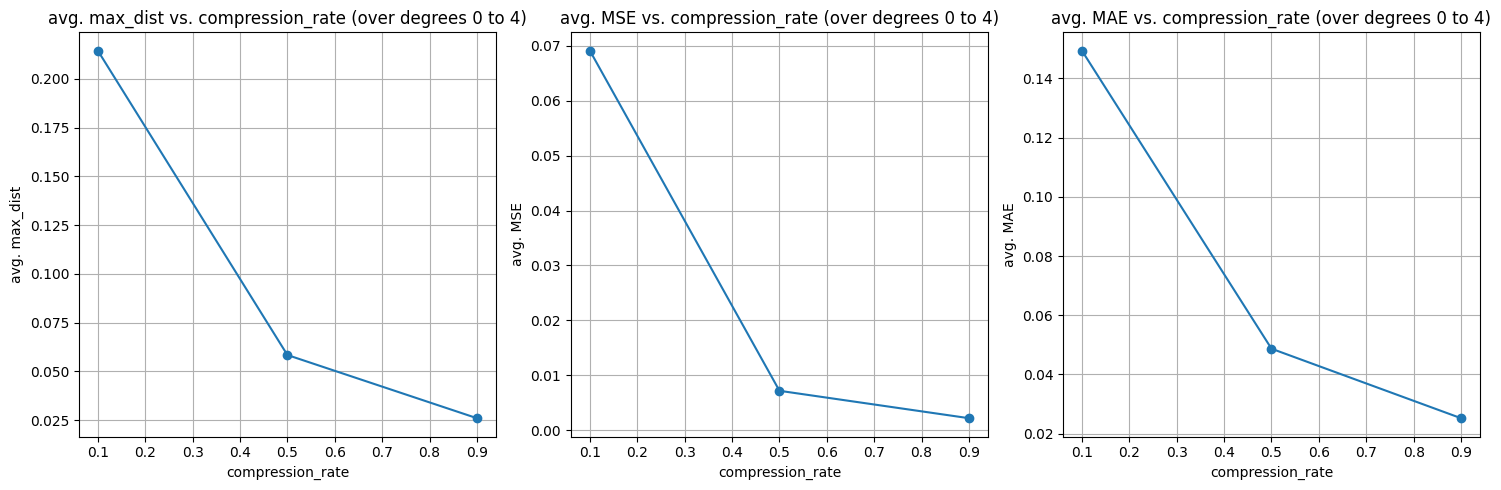

In [19]:
# avg max_dist/mse/mae (accuracy whatever) vs compression rate (avg. over all degrees)
avg_mse_by_compression_rate = df.groupby('compression_rate')['max_dist'].mean()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_mse_by_compression_rate = df.groupby('compression_rate')[metric].mean()
    axs[i].plot(avg_mse_by_compression_rate.index, avg_mse_by_compression_rate.values, marker='o', linestyle='-')
    axs[i].set_xlabel('compression_rate')
    axs[i].set_ylabel('avg. ' + metric)
    axs[i].set_title(
        'avg. ' + metric + ' vs. compression_rate (over degrees 0 to ' + str(max(df['degree'].unique())) + ')')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


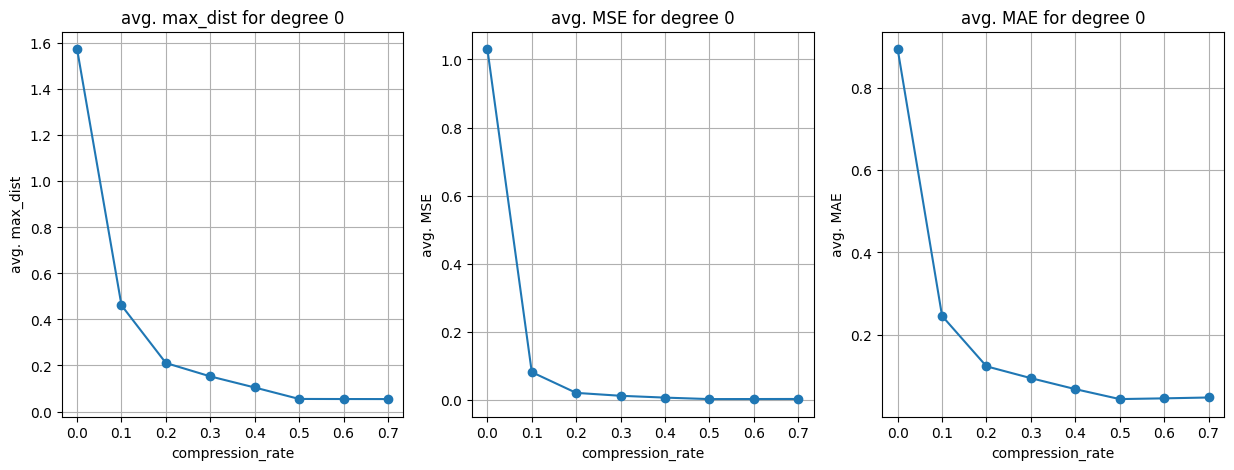

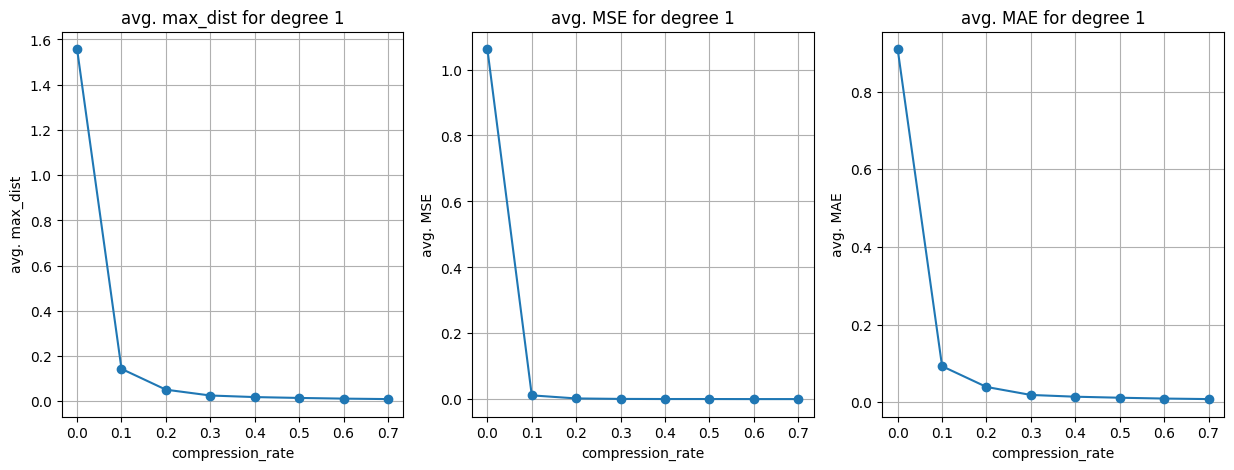

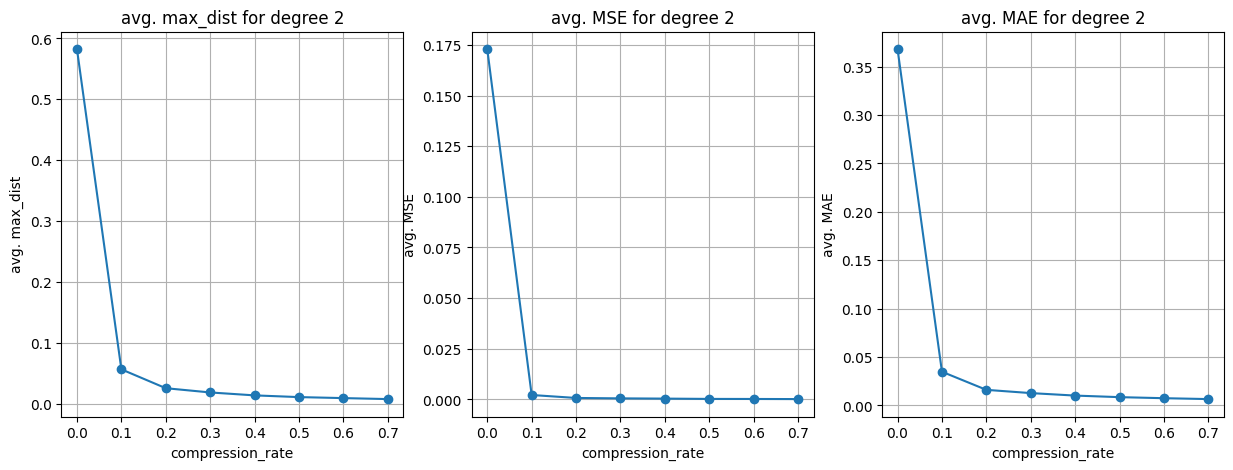

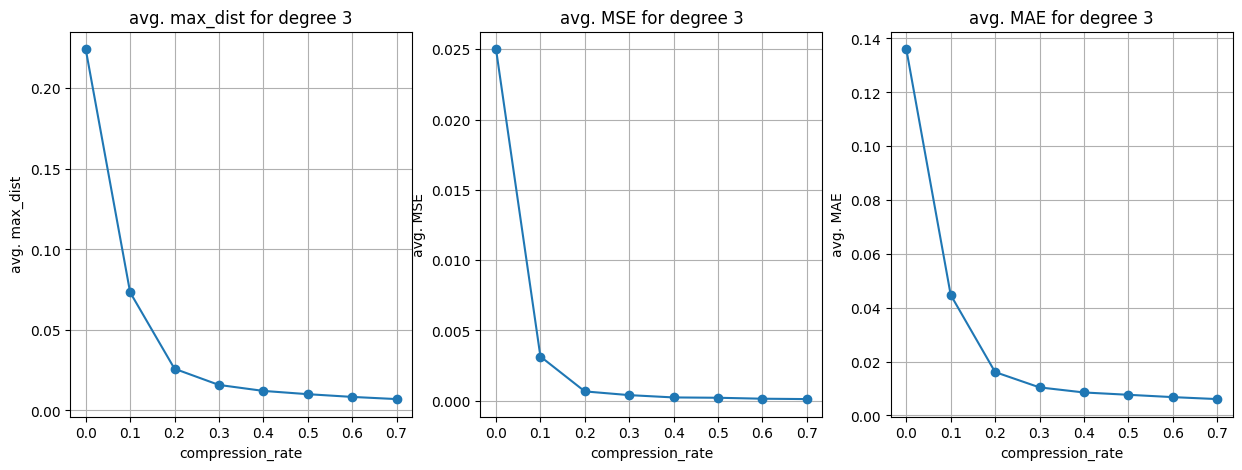

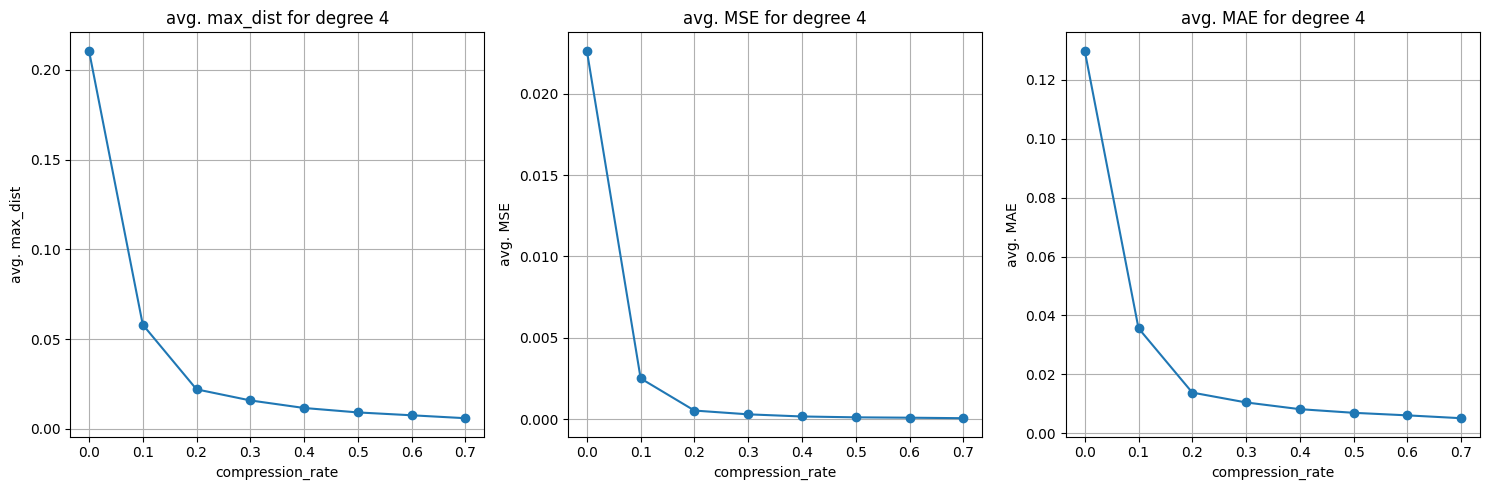

In [46]:
# compression rate vs. avg. accuracy metrics (for each degree)
for degree, group in df.groupby('degree'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sub_df = df[df['degree'] == degree]
    for i, metric in enumerate(metrics):
        avg_metric_by_compression = sub_df.groupby('compression_rate')[metric].mean()
        print()
        #x= df.groupby('degree')[metric].mean()
        axs[i].plot(avg_metric_by_compression.index, avg_metric_by_compression.values, marker='o', linestyle='-')
        axs[i].set_xlabel('compression_rate')
        axs[i].set_ylabel('avg. ' + metric)
        axs[i].set_title('avg. ' + metric + ' for degree ' + str(degree))
        axs[i].set_xticks(list(avg_metric_by_compression.index))
        axs[i].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [35]:
from load_data import remove_outliers, load_ucr_dataset

# load data to work with here
#data = normalize_datasets(load_ucr_archive())
data = load_ucr_dataset(47).normalize()
#data = normalize_datasets(load_gbnc_ngrams_as_datasets())

data_lof = remove_outliers(data)


In [36]:
# set other important global information here
eps = 0.0000001
#eps = 0.000001


In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]


n = 3  # degree of the spline
p = 8  # number of internal knots

knots = flatten((n + 1) * [[0]] + [[x / (p + 1)] for x in range(1, p + 1)] + (n + 1) * [[1]])

m = len(knots) - 1 - n  # number of control points (coefficients)

In [63]:
import matplotlib.colors as mcolors

print(mcolors)

<module 'matplotlib.colors' from 'C:\\Users\\veron\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\colors.py'>


The following function calculates different accuracy metrics for the different fitting method and returns them as a 2D array (one column for each fitting method).

In [ ]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline import evaluate_spline, calculate_max_dist
from fit import fit_max_spline, fit_max_l1_spline


def calculate_errors(data_tuples, knots, n):
    result1 = scipy.interpolate.make_lsq_spline([x[0] for x in data_tuples], [x[1] for x in data_tuples], knots, k=n).c
    result2 = fit_max_spline(data_tuples, knots, n)[1]
    result3 = fit_max_l1_spline(data_tuples, knots, n, eps=eps)[1]

    results = [result1, result2, result3]

    errors = []
    data_points = [x[1] for x in data_tuples]
    counter = 0
    for result in results:
        counter += 1
        fitted_spline = [evaluate_spline(knots, result, n, x[0]) for x in data_tuples]  #data_points]
        max_dist = calculate_max_dist(knots, result, n, data_tuples)[0]
        errors.append([max_dist,  # maximum absolute distance,
                       mean_squared_error(data_points, fitted_spline),  # MSE
                       sqrt(mean_squared_error(data_points, fitted_spline)),  # RMSE
                       mean_absolute_error(data_points, fitted_spline)  # MAE
                       ])

    return errors

Here, the accuracy metrics are averaged for a whole dataset.

In [ ]:
%%time
from math import sqrt
import pandas as pd
import numpy as np

assert (len(data) == len(data_lof))

# fit spline and measure errors
all_errors = []
for i in range(len(data)):
    errors = calculate_errors(data[i], knots, n)  #+ calculate_errors(data_lof[i], knots, n)
    all_errors.append(errors)

#row_names = ['LSQ', 'LSQ w/o outliers', 'Max', 'Max w/o outliers', 'Max and L1', 'Max and L1 w/o outliers']
row_names = ['LSQ', 'Max', 'Max and L1']

avg_errors = np.array([
    [sum(all_errors[x][i][j] for x in range(len(all_errors))) / len(all_errors) for j in range(len(all_errors[0][0]))]
    for i in range(len(all_errors[0]))
])

df = pd.DataFrame(avg_errors, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
df.columns = pd.MultiIndex.from_product([['avg. measures'], df.columns])
df.index = row_names
print(df)
print("n:", n)
print("p:", p)
print("eps:", eps)


In [ ]:
import numpy as np
import matplotlib.colors as mcolors


def plot_splines(axis, data, labels='None'):
    result1 = scipy.interpolate.make_lsq_spline([x[0] for x in data], [x[1] for x in data], knots, k=n).c
    t, result2 = fit_max_spline(data, knots, n)
    result3 = fit_max_l1_spline(data, knots, n, eps=eps)[1]

    results = [result1, result2, result3]
    max_dists = [calculate_max_dist(knots, result, n, data)[0] for result in results]
    colors = list(mcolors.BASE_COLORS.keys())

    xs = np.linspace(0, 1, num=1000)

    print("opt distance", t)

    for i in range(len(results)):
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) for x in xs], colors[i % len(colors)] + '-',
                  label=labels[i])
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) + max_dists[i] for x in xs],
                  colors[i % len(colors)] + '--')
        axis.plot(xs, [evaluate_spline(knots, results[i], n, x) - max_dists[i] for x in xs],
                  colors[i % len(colors)] + '--')

    axis.scatter([d[0] for d in data], [d[1] for d in data], marker='.')
    print("number of data points:", len(data))
    axis.legend()

In [ ]:
from matplotlib import pyplot as plt

row_names = ['LSQ', 'Max', 'Max and L1']
fitting_methods = [r'$L_2$', r'$L_{\infty}$', r'$L_{\infty}$ and $L_1$']
# single plot
for data_tuples in data:
    plot_splines(plt, data_tuples, fitting_methods)

    error_metrics = calculate_errors(data_tuples, knots, n)
    df = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df.index = row_names
    print(df)

    plt.show()

Both the original data and the data without outliers are plotted here.

In [ ]:
from matplotlib import pyplot as plt

fitting_methods = [r'$L_2$', r'$L_{\infty}$', r'$L_{\infty}$ and $L_1$']
# plot data and data without outliers next to each other
assert (len(data) == len(data_lof))
for i in range(len(data)):
    f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(12)

    error_metrics = calculate_errors(data[i], knots, n)
    df1 = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df1.index = row_names
    print(df1)

    plot_splines(axes[0], data[i], fitting_methods)
    axes[0].set_title("Data including outliers")
    #axes[0].table(cellText=df1.values.round(4), colLabels=df1.columns)

    error_metrics = calculate_errors(data_lof[i], knots, n)
    df2 = pd.DataFrame(error_metrics, columns=['max_dist', 'MSE', 'RMSE', 'MAE'])
    df2.index = row_names
    print(df2)

    plot_splines(axes[1], data_lof[i], fitting_methods)
    axes[1].set_title("Data without outliers")
    #axes[1].table(cellText=df2.values.round(4), colLabels=df2.columns)

    plt.subplots_adjust(bottom=0.25, top=0.95)

    plt.show()